In [1]:
import numpy as np
import random
from gensim.models import Word2Vec
import gensim.downloader
from scipy.stats import spearmanr
from gensim.models import KeyedVectors
import copy
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

# Configurações
POP_SIZE = 50
GEN_MAX = 30
MUT_RATE = 0.2
CROSS_RATE = 0.6
VECTOR_SIZE = 50

In [2]:
_glove_model = gensim.downloader.load('glove-wiki-gigaword-50')
_glove_model_changed = gensim.downloader.load('glove-wiki-gigaword-50')

In [3]:
#weat 6
female_attributes = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter']
male_attributes = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son']

careers = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition', 'poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

def load_dataset(filepath):
    word_pairs = []
    human_scores = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                word1, word2, score = parts
                score = float(score)
                word_pairs.append((word1.split('-')[0], word2.split('-')[0]))
                human_scores.append(score)
    return word_pairs, human_scores

filepath = 'MEN_dataset_lemma_form.dev'
word_pairs, human_scores = load_dataset(filepath)

men_words = []
for word1, word2 in word_pairs:
    men_words.append(word1)
    men_words.append(word2)

all_words = list(set(female_attributes + male_attributes + careers + men_words))

word_vectors = {word: _glove_model[word] for word in all_words if word in _glove_model}
vectors = np.array([word_vectors[word] for word in word_vectors.keys()])
words = list(word_vectors.keys())
reduced_glove = Word2Vec(vector_size=50, min_count=1)
reduced_glove.build_vocab([words])
reduced_glove.wv.vectors = vectors
reduced_glove.wv.index_to_key = words
reduced_glove.wv.key_to_index = {word: idx for idx, word in enumerate(words)}


In [4]:
def noise_vec(_size=VECTOR_SIZE):
    return np.random.uniform(-2, 2, size=_size)

def init_population():
    population = np.ones((POP_SIZE - 1, VECTOR_SIZE)) + np.array([noise_vec() for _ in range(POP_SIZE - 1)])
    population = np.vstack([population, np.ones(VECTOR_SIZE)])
    np.random.shuffle(population)
    return population

def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0:
        return 0.0
    return dot_product / (norm_v1 * norm_v2)

def wordembedding_similarity(word_pairs, model):
    embedding_similarities = []
    for word1, word2 in word_pairs:
        if word1 in model and word2 in model:
            v1 = model[word1]
            v2 = model[word2]
            similarity = cosine_similarity(v1, v2)
        else:
            similarity = 0.0
        embedding_similarities.append(similarity)
    return embedding_similarities

def calculate_costs(s, word_pairs, human_scores):
    glove_model_modified = copy.copy(reduced_glove.wv)
    
    for _word in all_words:
        glove_model_modified[_word] = np.multiply(glove_model_modified[_word], s)
        
    differences = [
        abs(
            sum(glove_model_modified.similarity(career, attr) for attr in female_attributes) / len(female_attributes) - 
            sum(glove_model_modified.similarity(career, attr) for attr in male_attributes) / len(male_attributes)
        )
        for career in careers
    ]
    
    bias = sum(differences)

    embedding_similarities = wordembedding_similarity(word_pairs, glove_model_modified)
    spearman_corr, _ = spearmanr(human_scores, embedding_similarities)
    cost_spearman = 1 - spearman_corr
    return [bias,cost_spearman]

In [5]:
class BiasSpearmanProblem(Problem):

    def __init__(self, word_pairs, human_scores):
        super().__init__(n_var=VECTOR_SIZE, n_obj=2, n_constr=0, xl=-2, xu=2)
        self.word_pairs = word_pairs
        self.human_scores = human_scores

    def _evaluate(self, s, out, *args, **kwargs):
        bias_costs = []
        spearman_costs = []
        for individual in s:
            bias, cost_spearman = calculate_costs(individual, self.word_pairs, self.human_scores)
            bias_costs.append(bias)
            spearman_costs.append(cost_spearman)
        out["F"] = np.column_stack([bias_costs, spearman_costs])

problem = BiasSpearmanProblem(word_pairs, human_scores)

algorithm = NSGA2(pop_size=POP_SIZE)

termination = get_termination("n_gen", GEN_MAX)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               verbose=True)

print("Soluções de Pareto:")
for sol in res.F:
    print(f"Bias: {sol[0]:.4f}, Spearman Cost: {sol[1]:.4f}")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      5 |             - |             -
     2 |      100 |      7 |  0.1435840200 |         ideal
     3 |      150 |      5 |  0.0115132226 |         ideal
     4 |      200 |      6 |  0.1355625966 |         ideal
     5 |      250 |      7 |  0.0669215770 |         ideal
     6 |      300 |      9 |  0.0431355222 |             f
     7 |      350 |      8 |  0.0156309893 |         ideal
     8 |      400 |     10 |  0.0585674393 |         ideal
     9 |      450 |     15 |  0.0159247960 |         ideal
    10 |      500 |     15 |  0.0074203566 |         ideal
    11 |      550 |     21 |  0.0547224840 |         ideal
    12 |      600 |     17 |  0.0340293240 |         ideal
    13 |      650 |     19 |  0.0290345897 |             f
    14 |      700 |     16 |  0.0062194959 |         ideal
    15 |      750 |     22 |  0.5231012146 |         nadir
    16 |      800 |     22 |  0.0849742809 |         ide

In [6]:
print(res.X)

[[-1.933879   -1.66656849 -0.30611564 ...  0.11471701  1.58142298
   1.29234857]
 [-1.92450237  1.26804027  0.13822508 ...  0.09056577  1.92967021
  -0.37086879]
 [-1.95937745 -1.66656849 -0.30611564 ...  0.18811579  1.58142298
   1.2934551 ]
 ...
 [-1.96222162  1.30113187 -0.27185024 ...  0.09056577  1.9388675
   0.11288228]
 [-1.98476404  1.35481103 -0.30448112 ...  0.09142602  1.93923353
   0.28133026]
 [-1.98102507  1.36239988 -0.3737486  ...  0.05564598  1.93923353
   0.28133026]]


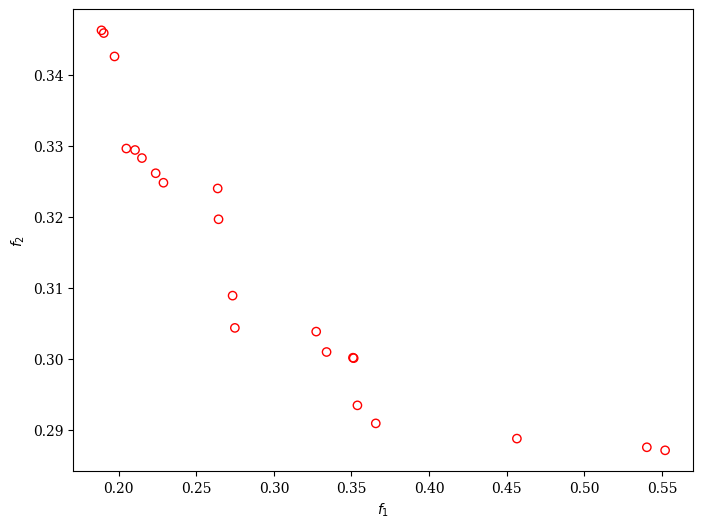

In [7]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()